<a href="https://colab.research.google.com/github/nastyh/Unbalanced-Dataset/blob/master/Unbalanced_Dataset_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Using Framingham
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
%matplotlib inline


In [2]:
#Loading stuff
from google.colab import files
uploaded = files.upload()

Saving framingham.csv to framingham.csv


In [0]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['framingham.csv']))

**Data Exploration**

In [0]:
# looking at stats
# pandas_profiling.ProfileReport(df)

In [5]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


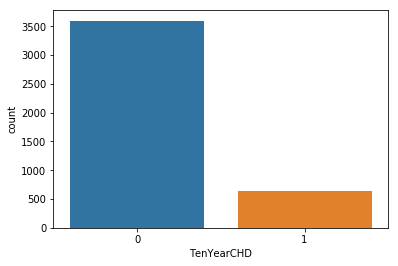

In [6]:
sns.countplot(x='TenYearCHD',data=df)

18.35624394966117

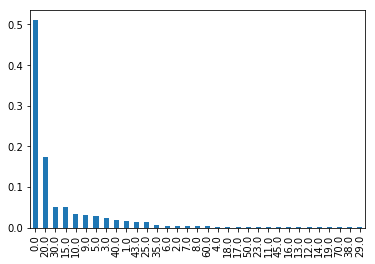

In [7]:
# Exploring cigsPerDay
df['cigsPerDay'].value_counts(normalize = True).plot(kind="bar")
df['cigsPerDay'][df['currentSmoker']==0].isna().sum()


# creating a boolean array of smokers
smoke = (df['currentSmoker']==1)
# applying mean to NaNs in cigsPerDay but using a set of smokers only
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())
df['cigsPerDay'][df['currentSmoker']==1].mean()

In [8]:
# Filling out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

df.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [0]:
# pandas_profiling.ProfileReport(df)

In [0]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1]

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 0)

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Scaling the whole dataset for possible K-fold validation:
X_scaled = sc.fit_transform(features)

# y_train = y_train.values
# y_train


**Network itself**

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [14]:
classifier = Sequential()

In [15]:
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['categorical_accuracy'])
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
# Fitting the ANN to the Training set
history1 = classifier.fit(X_train, y_train, validation_split=0.2, batch_size = 10, epochs = 300, verbose = 0)

In [17]:
# What history1 stores:
history1.history.keys()

dict_keys(['val_loss', 'val_sparse_categorical_accuracy', 'val_categorical_accuracy', 'val_binary_accuracy', 'val_acc', 'loss', 'sparse_categorical_accuracy', 'categorical_accuracy', 'binary_accuracy', 'acc'])

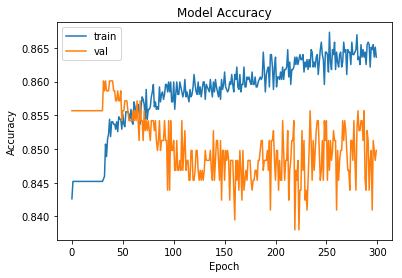

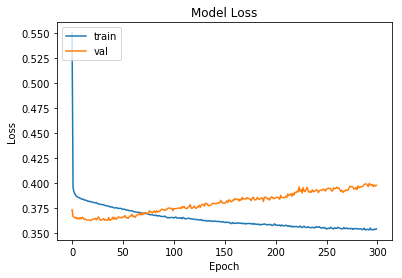

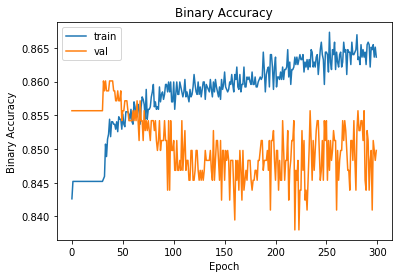

In [18]:
# plot metrics


plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history1.history['binary_accuracy'])
plt.plot(history1.history['val_binary_accuracy'])
plt.title('Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:
score1 = classifier.evaluate(X_train, y_train, verbose = 0)

In [20]:
print("For given metrics: {}".format(classifier.metrics_names))
print(score1)

For given metrics: ['loss', 'sparse_categorical_accuracy', 'categorical_accuracy', 'binary_accuracy', 'acc']
[0.36008926551297027, 0.8472877358490566, 1.0, 0.8626179245283019, 0.8626179245283019]


**Retrain the model with early stopping**

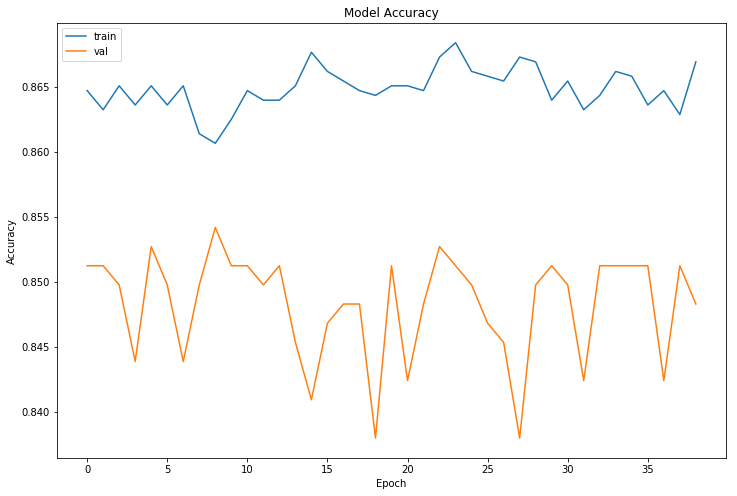

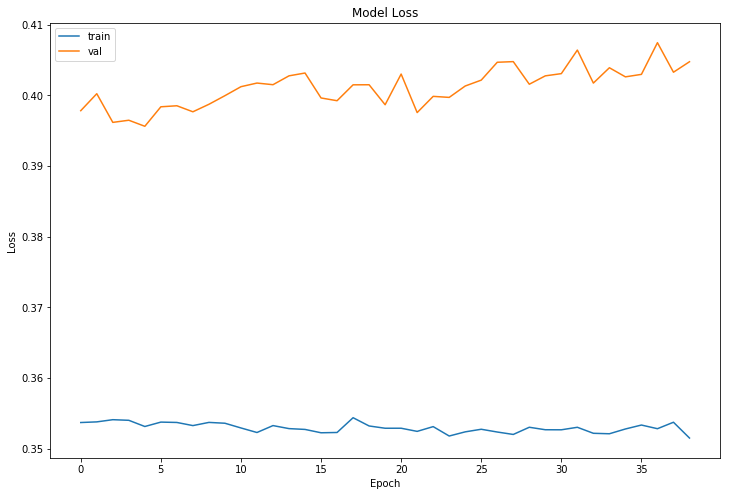

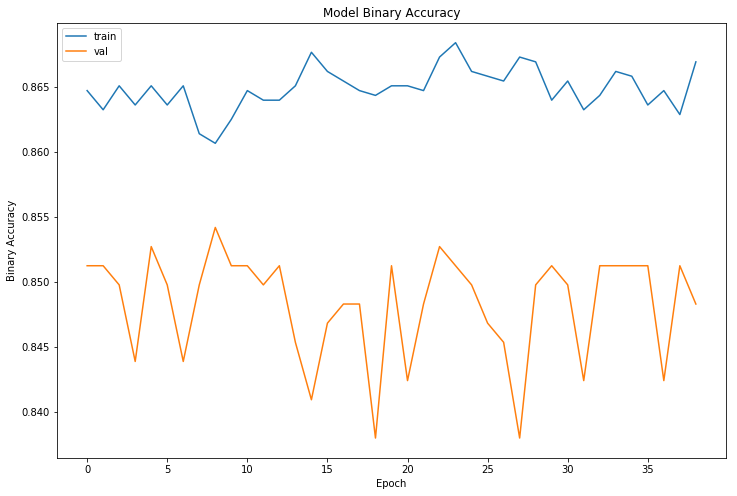

In [21]:
es = EarlyStopping(monitor='val_acc', mode='auto', verbose=0, patience=30)
history2 = classifier.fit(X_train, y_train, validation_split=0.2, batch_size = 10, epochs = 150, verbose = 0, callbacks=[es])

plt.figure(figsize=(12,8))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:
# how it will perform on the test data
y_pred = classifier.predict(X_test)

In [0]:
threshold = 0.5
y_pred = (y_pred < threshold).astype(np.int)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 25, 697],
       [ 16, 110]])

**With regularization**

In [0]:
from keras import regularizers

In [0]:
classifier_l2 = Sequential()

In [0]:
classifier_l2.add(Dense(units = 8, kernel_initializer = 'uniform', kernel_regularizer = regularizers.l2(0.001), activation = 'relu', input_dim= 15))
# Adding the second hidden layer
classifier_l2.add(Dense(units = 8, kernel_initializer = 'uniform', kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
# Adding the output layer
classifier_l2.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier_l2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])

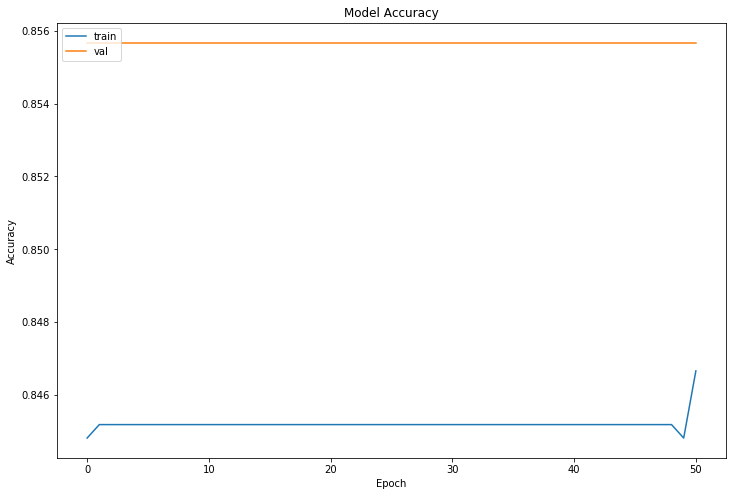

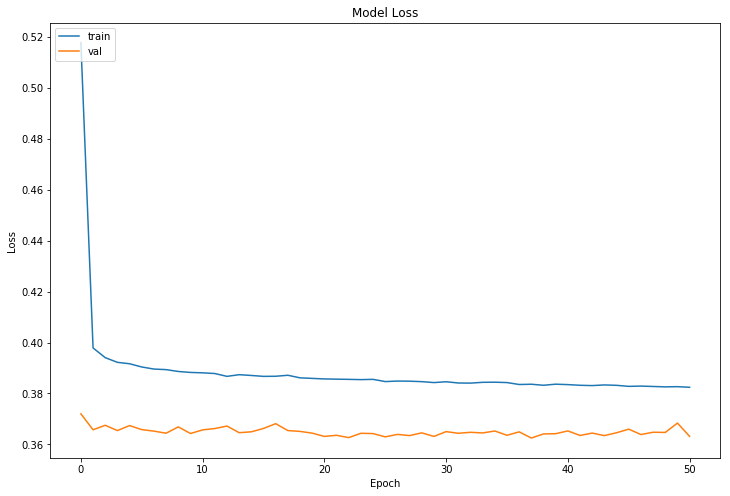

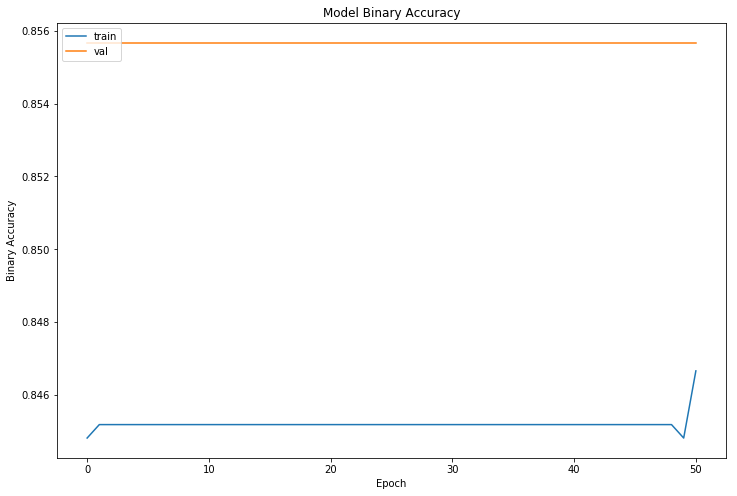

In [28]:
es = EarlyStopping(monitor='val_acc', mode='auto', verbose=0, patience=50)
history_l2 = classifier_l2.fit(X_train, y_train, validation_split=0.2, batch_size = 10, epochs = 200, verbose = 0, callbacks=[es])

plt.figure(figsize=(12,8))
plt.plot(history_l2.history['acc'])
plt.plot(history_l2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history_l2.history['binary_accuracy'])
plt.plot(history_l2.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


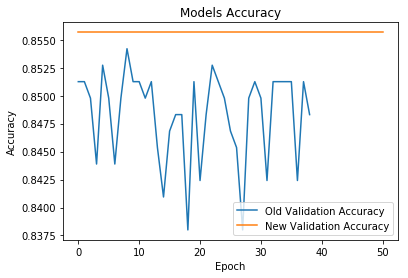

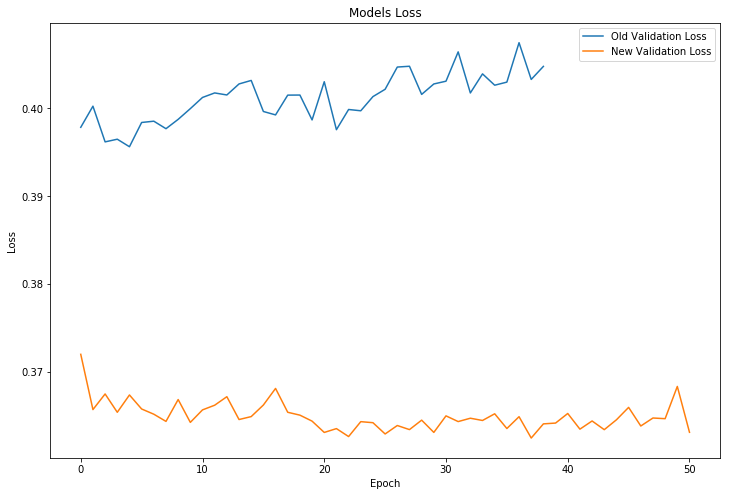

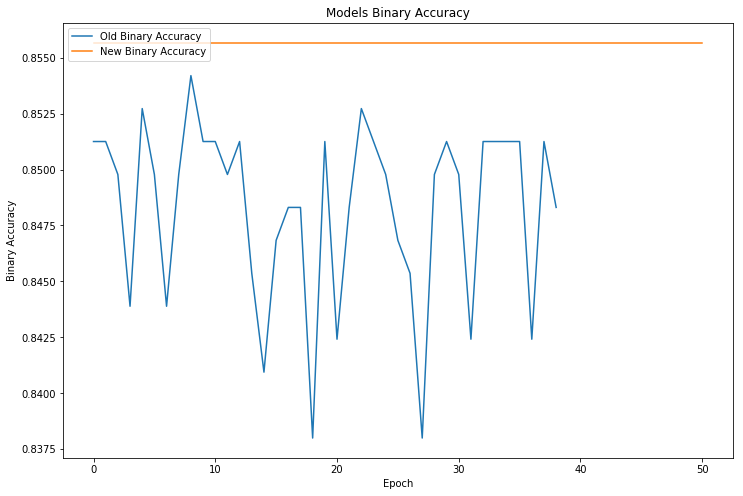

In [29]:
# Comparing old and new charts

plt.plot(history2.history['val_acc'])
plt.plot(history_l2.history['val_acc'])
plt.title('Models'' Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Old Validation Accuracy', 'New Validation Accuracy'], loc='lower right')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history2.history['val_loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('Models'' Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Old Validation Loss', 'New Validation Loss'], loc='upper right')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history2.history['val_binary_accuracy'])
plt.plot(history_l2.history['val_binary_accuracy'])
plt.title('Models'' Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Old Binary Accuracy', 'New Binary Accuracy'], loc='upper left')
plt.show()

In [0]:
# Making predictions
y_pred_l2 = classifier_l2.predict(X_test)

threshold = 0.4
y_pred_l2 = (y_pred_l2 < threshold).astype(np.int)

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_l2)
cm

array([[ 10, 712],
       [  8, 118]])

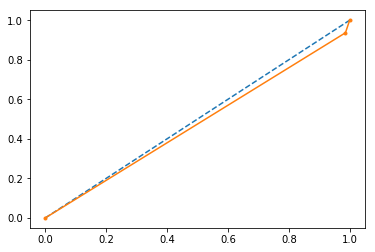

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_l2)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

Seems that the model can be trained more; poor performance on the test set.
Looking at the loss, we can conclude that after around ~50 epochs the model starts to overfit.

In [0]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

In [34]:
# TAKES TIME
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])
    return classifier
  
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 300)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

print("Mean accuracy is {}\nVariance is {}".format(mean, variance))

Mean accuracy is 0.8410966461118095
Variance is 0.01578380941242091


**Let's use Optimizers**

In [0]:
# history1 = classifier.fit(X_train, y_train, validation_split=0.2, batch_size = 10, epochs = 300, verbose = 0)

In [0]:
classifier = Sequential()
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])

In [45]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.0051, decay=1e-6, momentum=0.9, nesterov=True)
classifier.fit(X_train, y_train, validation_split=0.2, batch_size = 10, epochs = 300, verbose = 0)



In [0]:
classifier.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])

In [0]:
history3 = classifier.fit(X_train, y_train, validation_split=0.2, batch_size = 10, epochs = 300, verbose = 0)

# Making predictions
y_pred_sgd = classifier.predict(X_test)

threshold = 0.4
y_pred_sgd = (y_pred_sgd < threshold).astype(np.int)


In [49]:
cm_sgd = confusion_matrix(y_test, y_pred_sgd)
cm_sgd

array([[ 36, 686],
       [ 13, 113]])

In [52]:
from sklearn.metrics import classification_report
target_names = ['Develop', 'Do not develop']
print(classification_report(y_test, y_pred_sgd, target_names=target_names))

                precision    recall  f1-score   support

       Develop       0.73      0.05      0.09       722
Do not develop       0.14      0.90      0.24       126

      accuracy                           0.18       848
     macro avg       0.44      0.47      0.17       848
  weighted avg       0.65      0.18      0.12       848



In [0]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

In [0]:
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
  
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

In [55]:
print("Mean of accuracies is {},\nand the variance is {}".format(mean, variance))

Mean of accuracies is 0.8469937476121199,
and the variance is 0.009984480772300686


***Implementing drop-out***

In [0]:
from keras.layers import Dropout

In [0]:
classifier = Sequential()

In [58]:
# rebuilding this time doing dropout for every layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
classifier.add(Dropout(p=0.1)) # meaning 10% will be dropped duting the learning stage
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(p=0.1))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 300, verbose = 0)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.


In [0]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.4)

In [60]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[712,  10],
       [118,   8]])

In [61]:
target_names = ['Develop', 'Do not develop']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

       Develop       0.86      0.99      0.92       722
Do not develop       0.44      0.06      0.11       126

      accuracy                           0.85       848
     macro avg       0.65      0.52      0.51       848
  weighted avg       0.80      0.85      0.80       848



**Passing class weight manually**

In [0]:
# # Tuning the ANN
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# from keras.models import Sequential
# from keras.layers import Dense

# def build_classifier(optimizer):
#     classifier = Sequential()
#     classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
#     classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
#     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
#     classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return classifier

# classifier = KerasClassifier(build_fn = build_classifier)
# parameters = {'batch_size': [25, 27, 30, 32],
#               'epochs': [100, 200, 300, 400, 500],
#               'optimizer': ['adam', 'rmsprop']}
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 10)
# grid_search = grid_search.fit(X_train, y_train)
# best_parameters = grid_search.best_params_
# best_accuracy = grid_search.best_score_

In [0]:
# TAKES TIME
# doing K-fold validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

skf = StratifiedKFold(5, shuffle = True, random_state = 15)

oos_y = []
oos_pred = []

fold = 0
for train, test in skf.split(X_scaled, result): #passing 
  fold +=1
  print("Fold #{}".format(fold))
  
#   x_train = X_train[train]
#   y_train = y_train[train]
#   x_test = X_test[test]
#   y_test = y_test[test]
  x_train = X_scaled[train]
  y_train = result[train]
  x_test = X_scaled[test]
  y_test = result[test]
  
  classifier = Sequential()
  classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim= 15))
  classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['sparse_categorical_accuracy', 'categorical_accuracy','binary_accuracy', 'accuracy'])
  
  classifier.fit(x_train, y_train, batch_size = 10, epochs = 500)
  
  y_pred = classifier.predict(x_test)
  y_pred = (y_pred > 0.4)
  
  oos_y.append(y_test)
  oos_pred.append(y_pred)
  
  # Measuring each fold's RMSE:
  score = np.sqrt(mean_squared_error(y_pred, y_test))
  print("Fold's #{} score is {}".format(fold, score))
  
# Out-of-sample prediction list and the error
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(mean_squared_error(oos_pred, oos_y))
print("Final score is {}".format(score))

# Final score is 0.40921000743955327